In [2]:
import numpy as np
import random as rnd
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

ImportError: cannot import name 'execute' from 'qiskit' (c:\Users\Raque\AppData\Local\Programs\Python\Python312\Lib\site-packages\qiskit\__init__.py)

# <center> QAOA
### <center> Implementação do QAOA e comparação com a implementação do qiskit para disciplina de Computação Quântica.
<center> Raquel Silveira de Araújo, Unversidade Federal de Pernambuco, Período letivo 2023.1

In [ ]:
def qaoa_circuit(graph, gamma, beta):
    '''
    graph: networkx.Graph()
    gamma, beta: listas de ângulos de tamanho igual à quantidade de camadas (p)
    '''
    p = len(gamma)
    n = graph.number_of_nodes()
    qc = QuantumCircuit(n,n)
    qc.h(range(n))
    for k in range(p):
        # Operador custo: cnot, Rz, cnot
        for i,j in graph.edges():
            qc.cx(i,j)
            qc.rz(2*gamma[k],j)
            qc.cx(i,j)
        qc.barrier()
        # Operador mixer: Rotação Rx para cada qbit do sistema
        for i in graph.nodes():
            qc.rx(2*beta[k], i)
        qc.barrier()
    qc.measure(range(n),range(n))
    return qc

# <center> Parâmetros

### Preparação de grafos de exemplo:

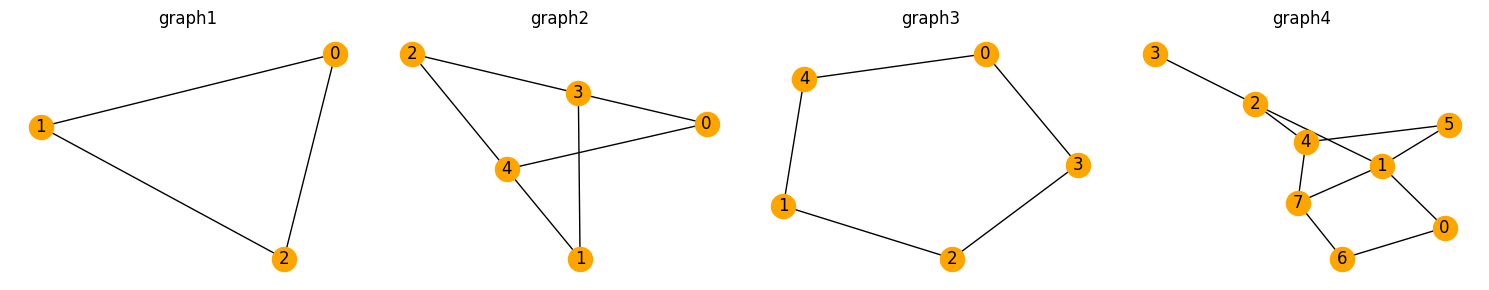

In [ ]:
# graph2: Triângulo
graph1 = nx.Graph()
graph1.add_edges_from([[0,1],[0,2],[1,2]])

# graph1: Grafo bipartido
graph2 = nx.Graph()
graph2.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])

# graph3: Pentagrama (grau fixo = 2) forma um "anel"
graph3 = nx.Graph()
graph3.add_edges_from([[0,3],[0,4],[1,2],[1,4],[2,3]])

# graph4: Um grafo maior de 8 vértices
graph4 = nx.Graph()
graph4.add_edges_from([[0,1],[0,6],[1,2],[1,5],[1,7],[2,3],[2,4],[4,5],[4,7],[6,7]])

# Criando um dicionário
graph_dict = {
    'graph1': graph1,
    'graph2': graph2,
    'graph3': graph3,
    'graph4': graph4
}

# Create a single plot with 5 subfigures
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 3))
for i, (key, graph) in enumerate(graph_dict.items()):
    ax = axes[i]
    nx.draw(graph, with_labels=True, ax=ax, node_color = 'orange')
    ax.set_title(key)

plt.tight_layout()
plt.show()

### Preparação de ângulos de exemplo

In [ ]:
def test_angles(p):
    # Repete o ângulo np.pi/3 p vezes para gamma e beta
    gamma = []
    beta = []
    for i in range(p):
        gamma.append(np.pi/3)
        beta.append(np.pi/3)
    return gamma, beta

def random_angles(p):
    #cria listas de ângulos gamma e beta aleatórios de tamanho p
    gamma = []
    beta = []
    for _ in range(p):
        gamma.append(rnd.uniform(0,np.pi))
        beta.append(rnd.uniform(0,np.pi))
    return gamma, beta

# <center> Plotando o Circuito Completo
<center> Plot do circuito para p=1 e gamma = theta = [np.pi/3]

In [ ]:
graph = graph1
gamma, beta = test_angles(p=1)
circuito = qaoa_circuit(graph, gamma, beta)
circuito.draw(fold=215)

┌───┐                                                                   ░ ┌──────────┐ ░ ┌─┐      
q_0: ┤ H ├──■────────────────■────■────────────────■─────────────────────────░─┤ Rx(2π/3) ├─░─┤M├──────
     ├───┤┌─┴─┐┌──────────┐┌─┴─┐  │                │                         ░ ├──────────┤ ░ └╥┘┌─┐   
q_1: ┤ H ├┤ X ├┤ Rz(2π/3) ├┤ X ├──┼────────────────┼────■────────────────■───░─┤ Rx(2π/3) ├─░──╫─┤M├───
     ├───┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐┌─┴─┐┌──────────┐┌─┴─┐ ░ ├──────────┤ ░  ║ └╥┘┌─┐
q_2: ┤ H ├──────────────────────┤ X ├┤ Rz(2π/3) ├┤ X ├┤ X ├┤ Rz(2π/3) ├┤ X ├─░─┤ Rx(2π/3) ├─░──╫──╫─┤M├
     └───┘                      └───┘└──────────┘└───┘└───┘└──────────┘└───┘ ░ └──────────┘ ░  ║  ║ └╥┘
c: 3/══════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩═
                                                                                               0  1  2

# <center> Executando o Código

### Funções auxiliares

In [ ]:
def maxcut_evaluation(graph, partition):#Função avaliação dos cortes para MaxCut
    cut = 0
    for i, j in graph.edges():
        if partition[i] != partition[j]:
            cut -= 1 #Está subtraindo para virar problema de minimização
    return cut

def maxcut_energy(measurements, graph): # Média ponderada dos cortes
    # measurements é um dicionário onde a chave é a medida (ex:'001011') e o item é a quantidade de ocorrências
    energy = 0
    total = 0
    for partition, partition_count in measurements.items():
        cuts = maxcut_evaluation(graph,partition)
        energy += cuts * partition_count
        total += partition_count
    return energy / total

def invert_counts(counts): # Apenas muda a ordem dos cortes
    return {k[::-1]:v for k, v in counts.items()}

### Função Completa

In [ ]:
def execute_qaoa(graph, gamma, beta):
    # Simulador:
    simulator = Aer.get_backend('qasm_simulator')

    # Roda o circuito e salva os resultados:
    quantum_circuit = qaoa_circuit(graph,gamma,beta)
    result = execute(quantum_circuit,simulator).result()
    measurements = invert_counts(result.get_counts())
    
    energy = maxcut_energy(measurements, graph)
    return measurements, energy

In [ ]:
measurements, energy = execute_qaoa(graph, gamma, beta)

print('Resultados para gamma =', gamma,' beta=', beta, 'e grafo', graph)
print('Medidas: ', measurements)
print('Energia: ', energy)

Resultados para gamma = [1.0471975511965976]  beta= [1.0471975511965976] e grafo Graph with 3 nodes and 3 edges
Medidas:  {'111': 476, '000': 502, '010': 7, '100': 8, '001': 7, '101': 5, '011': 13, '110': 6}
Energia:  -0.08984375


### Loop Otimizador Aleatório

Executa o QAOA para ângulos aleatórios repetidamente, salvando os resultados de melhor desempenho

In [ ]:
def random_optimizer(graph, p, num_attempts, comment_lines = False):
    best_gamma = []
    best_beta = []
    best_results = []
    best_energy = 0

    for i in range(num_attempts):
        gamma, beta = random_angles(p)
        measurements, energy = execute_qaoa(graph, gamma, beta)

        if comment_lines == True:
            print('Resultados #',i,':')
            print('Energia: ', energy)
            print('gamma: ', gamma)
            print('beta:', beta)
            print('Medidas: ', measurements)

        if energy <= best_energy:
            best_gamma = gamma
            best_beta = beta
            best_results = measurements
            best_energy = energy
            if comment_lines == True:
                print('Melhor energia atual')
    
    return best_results, best_energy, best_gamma, best_beta

In [ ]:
best_results, best_energy, best_gamma, best_beta = random_optimizer(graph4, p=5, num_attempts=30, comment_lines= False)

print('Melhor energia: ', best_energy)
print('Melhores ângulos:')
print('Gamma: ', best_gamma)
print('Beta: ', best_beta)
print('Medidas: ')
print(best_results)

Melhor energia:  -6.166015625
Melhores ângulos:
Gamma:  [1.66372735838613, 1.8573703255471081, 2.7678562263876647, 0.9723579554344111, 0.5219372606149362]
Beta:  [0.48403113077367116, 0.2944408653077376, 2.3706046529705085, 0.13928590357745171, 1.667024815628937]
Medidas: 
{'10010000': 2, '00000101': 4, '01110001': 8, '01001010': 37, '10010101': 30, '00000000': 3, '01011001': 10, '10110110': 6, '00111101': 2, '01101010': 28, '00000110': 4, '10000110': 1, '10111000': 8, '10110101': 39, '01011100': 1, '11001010': 6, '11111101': 5, '11100101': 9, '11111010': 5, '10001010': 1, '10111101': 11, '10011110': 10, '01111010': 5, '01000001': 11, '10011011': 1, '11011111': 2, '10100101': 47, '00110110': 8, '00011110': 4, '01011010': 47, '01100001': 10, '00110011': 1, '01000010': 6, '10000010': 3, '10111110': 13, '01000111': 7, '01101001': 4, '11011001': 18, '01111011': 4, '01110011': 2, '11100111': 5, '10101100': 1, '11101010': 10, '11011101': 5, '10100100': 3, '10000100': 5, '01010110': 12, '1000

# <center> Resultado

Plot dos grafos particionados

In [ ]:
def graph_plots(graph, measurements):
    most_common_partition = ''
    best_partition = ''
    c = 0
    best_cut = 0
    for partition, count in measurements.items():
        cuts = maxcut_evaluation(graph,partition)
        if cuts <= best_cut:
            best_cut = cuts
            best_partition = partition
        if count > c:
            c = count
            most_common_partition = partition
    
    colors_1 = ['orange' if best_partition[node] == '0' else 'k' for node in graph]
    colors_2 = ['orange' if most_common_partition[node] == '0' else 'k' for node in graph]
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plot graph with color scheme 1
    nx.draw(graph, ax=ax1, with_labels=True, node_color=colors_1)
    ax1.set_title('Melhor resultado')

    # Plot graph with color scheme 2
    nx.draw(graph, ax=ax2, with_labels=True, node_color=colors_2)
    ax2.set_title('Resultado mais comum')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

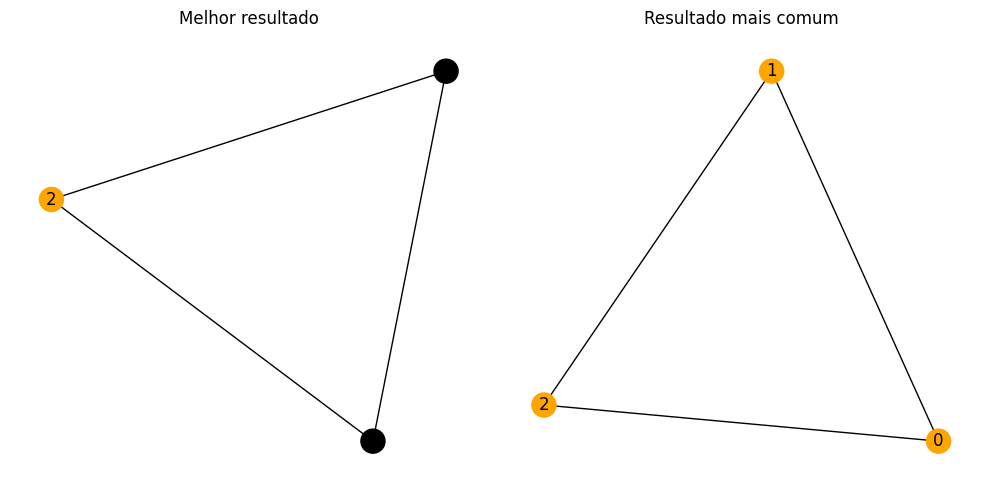

In [ ]:
graph_plots(graph, measurements)

# Mais Exemplos

In [ ]:
best_results, best_energy, best_gamma, best_beta = random_optimizer(graph4, p=5, num_attempts=30, comment_lines= False)

print('Melhor energia: ', best_energy)
print('Melhores ângulos:')
print('Gamma: ', best_gamma)
print('Beta: ', best_beta)
print('Medidas: ')
print(best_results)

graph_plots(graph, measurements)